# Pareto Frontiers for Toggling Frame Objective: Robustness & Fidelity Trade-off


## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using Random

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


In [2]:
# Problem parameters
T = 35
Δt = 0.2
U_goal = GATES.X
H_drive = [PAULIS.X, PAULIS.Y]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)

QuantumSystem: levels = 2, n_drives = 2

In [3]:
propertynames(sys)

(:H, :G, :n_drives, :levels, :params)

In [4]:
typeof(sys.H)

PiccoloQuantumObjects.QuantumSystems.var"#6#15"{SparseMatrixCSC{ComplexF64, Int64}, Vector{SparseMatrixCSC{ComplexF64, Int64}}}

In [5]:
length(sys.H.H_drives)
X_drive = sys.H.H_drives[1]
X_drive === H_drive[1]

false

In [6]:
randn(2, T)

2×30 Matrix{Float64}:
  0.305254  -1.60241  -0.986347   1.62315  …  -0.833095  0.633587  0.330112
 -0.185967  -1.79241   1.64028   -1.60218      1.79806   0.283391  0.665113

### Pareto Frontiers

In [8]:
n_guesses = 2
n_drives = sys.n_drives
a_guess = [2 .* rand(2, T) .- 1 for _ in 1:n_guesses]
a_bounds = fill(1/Δt, n_drives)
da_bounds = fill(1.0, n_drives)
dda_bounds = fill(1.0, n_drives)
control_bounds = (a_bounds, da_bounds, dda_bounds)
def_seeds = []
add_seeds = []
mult_seeds = []
both_seeds = []
n_seeds = n_guesses


for i in 1:n_seeds
    def_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=sys
                )
    push!(def_seeds, def_traj)

    add_traj = initialize_trajectory(
                    U_goal,
                    T,
                    Δt,
                    n_drives,
                    control_bounds;
                    a_guess=deepcopy(a_guess[i]),
                    system=sys
                )
    push!(add_seeds, add_traj)

    mult_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=sys
            )
    push!(mult_seeds, mult_traj)

    both_traj = initialize_trajectory(
                U_goal,
                T,
                Δt,
                n_drives,
                control_bounds;
                a_guess=deepcopy(a_guess[i]),
                system=sys
            )
    push!(both_seeds, both_traj)
end



In [9]:
a_guess[1]

2×35 Matrix{Float64}:
 0.701941  -0.966699   0.530515  …  -0.183675  -0.419459  -0.24191
 0.537281   0.241663  -0.100918     -0.728793  -0.172406   0.122632

In [10]:
final_fid_floor = [1-10.0^(-a) for a in 2:1:5]
n_nines = length(final_fid_floor)
default_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
init_both_probs = Matrix{Any}(undef, n_seeds, n_nines)


init_def_fids = Matrix{Any}(undef, n_seeds, n_nines)
init_add_fids = Matrix{Any}(undef, n_seeds, n_nines)
init_mult_fids = Matrix{Any}(undef, n_seeds, n_nines)

for i in 1:n_seeds
    for j in 1:n_nines
        default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; a_guess=deepcopy(a_guess[i]))
        default_probs[i, j] = default
        def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
        init_def_fids[i,j] = def_fid

        add_tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; a_guess=deepcopy(a_guess[i]))
        init_add_probs[i, j] = add_tog_prob
        add_fid = unitary_rollout_fidelity(init_add_probs[i, j].trajectory, sys)
        init_add_fids[i,j] = add_fid

        mult_tog_prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt; a_guess=deepcopy(a_guess[i]))
        init_mult_probs[i, j] = mult_tog_prob
        mult_fid = unitary_rollout_fidelity(init_mult_probs[i, j].trajectory, sys)
        init_mult_fids[i,j] = mult_fid
    end
end

takes = fill(1, n_nines)

for i in 1:n_seeds
    for j in 1:n_nines
        takes = 1
        while takes < 10 && init_def_fids[i,j] < final_fid_floor[j]
            solve!(default_probs[i, j]; max_iter=5, print_level=1)
            def_fid = unitary_rollout_fidelity(default_probs[i, j].trajectory, sys)
            init_def_fids[i, j] = def_fid
            takes += 1
        end

        takes = 1
        while takes < 10 && init_add_fids[i,j] < final_fid_floor[j]  
            solve!(init_add_probs[i, j]; max_iter=5, print_level=1)
            add_fid = unitary_rollout_fidelity(init_add_probs[i, j].trajectory, sys)
            init_add_fids[i, j] = add_fid
            takes += 1
        end

        takes = 1
        while takes < 10 && init_mult_fids[i,j] < final_fid_floor[j]  
            solve!(init_mult_probs[i, j]; max_iter=5, print_level=1)
            mult_fid = unitary_rollout_fidelity(init_mult_probs[i, j].trajectory, sys)
            init_mult_fids[i, j] = mult_fid
            takes += 1
        end
    end
end


    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :

Summary Table

In [11]:
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Min f | Base Fidelity | Add Fidelity | Mult Fidelity ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            add_fid = unitary_rollout_fidelity(init_add_probs[seed_idx, j].trajectory, sys)
            mult_fid = unitary_rollout_fidelity(init_mult_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Min f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.995631 |     0.995631 |      0.995631 |"

"  0.999 |     0.999584 |     0.999584 |      0.999584 |"

" 0.9999 |     0.999936 |     0.999936 |      0.999936 |"

"0.99999 |     0.999998 |     0.999998 |      0.999998 |"

"\nseed idx = 2:"

"Min f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.997688 |     0.997688 |      0.997688 |"

"  0.999 |     0.999946 |     0.999946 |      0.999946 |"

" 0.9999 |     0.999946 |     0.999946 |      0.999946 |"

"0.99999 |     0.999987 |     0.999987 |      0.999987 |"

Solve Max-Toggle Problems

In [12]:
final_fid_floor = [1-10.0^(-a) for a in 2:1:5]
n_nines = length(final_fid_floor)
final_add_probs = Matrix{Any}(undef, n_seeds, n_nines)
final_mult_probs = Matrix{Any}(undef, n_seeds, n_nines)
# final_both_probs = Matrix{Any}(undef, n_seeds, n_nines)

for i in 1:n_seeds
    for j in 1:n_nines
        Hₑ_add = a -> PAULIS.X
        add_prob = UnitaryMaxToggleProblem(
                init_add_probs[i,j],
                U_goal,
                Hₑ_add;
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(add_prob, max_iter=150, print_level=5)
        final_add_probs[i,j] = add_prob

        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive

        mult_prob = UnitaryMaxToggleProblem(
                init_mult_probs[i,j],
                U_goal,
                Hₑ_mult;
                final_fidelity=final_fid_floor[j],
                piccolo_options=piccolo_opts
            )
        solve!(mult_prob, max_iter=150, print_level=5)
        final_mult_probs[i,j] = mult_prob

        # Hₑ_both = a -> PAULIS.X + a[1] * X_drive
        # both_prob = UnitaryToggleProblem(
        #     sys, U_goal, T, Δt, Hₑ_both;
        #     piccolo_options=piccolo_opts
        #     )
        # solve!(both_prob, max_iter=150, print_level=5)

    end
end



    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     2720
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:    75934

Total number of variables............................:      513
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      171
                     variables with only upper bounds:        0
Total number of equality constraints.................:      442
Total number o

Pareto Frontiers

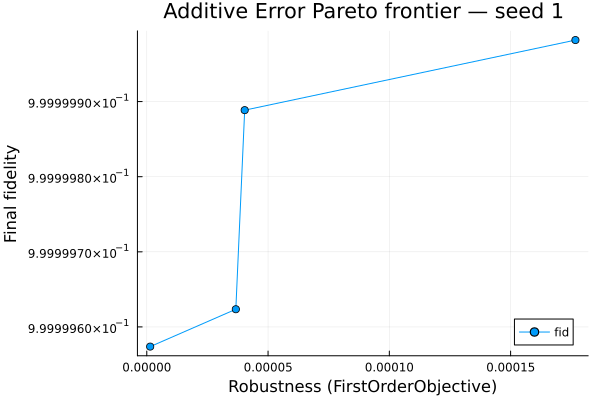

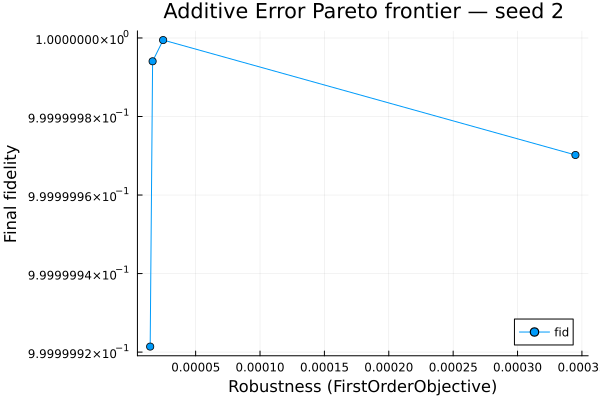

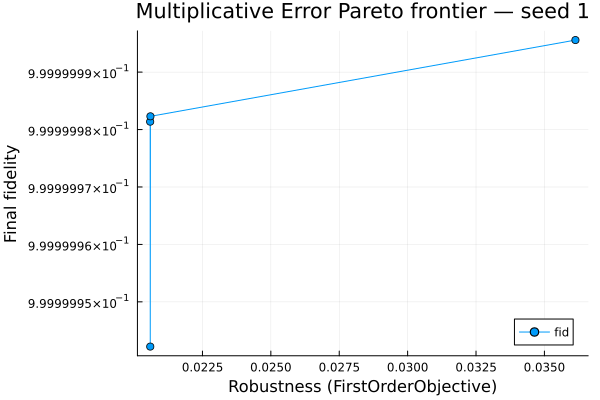

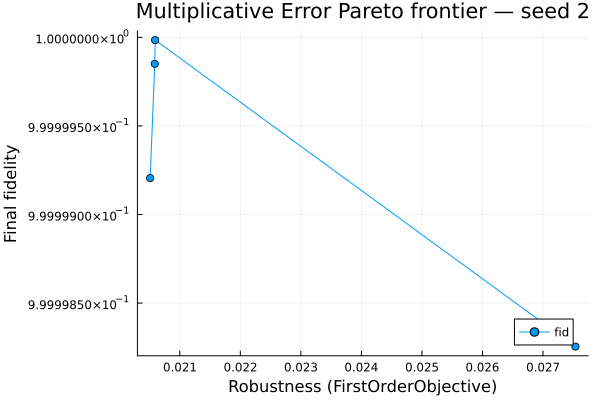

In [13]:
# robustness_value(traj::NamedTrajectory, H_err::Function, λ::Float64) = begin
#     rob = FirstOrderObjective(H_err, traj; Q_t=λ)  # your safe version
#     Z   = vcat(traj.datavec, traj.global_data)
#     rob.L(Z)
# end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (FirstOrderObjective)",
        ylabel="Final fidelity",
        title="Additive Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true
    )
    xs = Float64[]
    ys = Float64[]
    for (j, f) in enumerate(final_fid_floor)
        add_prob = final_add_probs[s, j]
        Hₑ_add = a -> PAULIS.X
        obj = FirstOrderObjective(Hₑ_add, add_prob.trajectory)
        Z_vec = vec(add_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, unitary_rollout_fidelity(add_prob.trajectory, sys))
    end
    # sort by x for a nice line
    ord = sortperm(xs)
    name = "fid"
    Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=name)
    display(plt)
end

for s in 1:n_seeds
    plt = Plots.plot(
        xlabel="Robustness (FirstOrderObjective)",
        ylabel="Final fidelity",
        title="Multiplicative Error Pareto frontier — seed $s",
        legend=:bottomright, grid=true
    )
    xs = Float64[]  # robustness
    ys = Float64[]  # fidelity
    for (j, f) in enumerate(final_fid_floor)
        mult_prob = final_mult_probs[s, j]
        X_drive = sys.H.H_drives[1]
        Hₑ_mult = a -> a[1] * X_drive
        obj = FirstOrderObjective(Hₑ_mult, mult_prob.trajectory)
        Z_vec = vec(mult_prob.trajectory)
        obj_val = obj.L(Z_vec)
        push!(xs, obj_val)
        push!(ys, unitary_rollout_fidelity(mult_prob.trajectory, sys))
    end
    # sort by x for a nice line
    ord = sortperm(xs)
    name = "fid"
    Plots.plot!(plt, xs[ord], ys[ord], marker=:circle, label=String(name))
    display(plt)
end

In [14]:
H_drive_add = H_drive
εs = 0:0.005:0.2
colors = Makie.wong_colors()

# Get fid for each problem
for seed_idx in 1:n_seeds
    display("\nseed idx = $seed_idx:")
    display("Final f | Base Fidelity | Add Fidelity | Mult Fidelity ")
    display("-" ^ 40)
    for (j, f) in enumerate(final_fid_floor)
            def_fid = unitary_rollout_fidelity(default_probs[seed_idx, j].trajectory, sys)
            add_fid = unitary_rollout_fidelity(final_add_probs[seed_idx, j].trajectory, sys)
            mult_fid = unitary_rollout_fidelity(final_mult_probs[seed_idx, j].trajectory, sys)
            display("$(lpad(round(f, digits=6), 7)) | $(lpad(round(def_fid, digits=6), 12)) | $(lpad(round(add_fid, digits=6), 12)) | $(lpad(round(mult_fid, digits=6), 13)) |")
    end
end

"\nseed idx = 1:"

"Final f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.998526 |          1.0 |           1.0 |"

"  0.999 |     0.999214 |          1.0 |           1.0 |"

" 0.9999 |     0.999954 |          1.0 |           1.0 |"

"0.99999 |     0.999998 |          1.0 |           1.0 |"

"\nseed idx = 2:"

"Final f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.997121 |          1.0 |           1.0 |"

"  0.999 |     0.999125 |     0.999989 |      0.999977 |"

" 0.9999 |     0.999996 |          1.0 |           1.0 |"

"0.99999 |     0.999996 |          1.0 |           1.0 |"

"\nseed idx = 3:"

"Final f | Base Fidelity | Add Fidelity | Mult Fidelity "

"----------------------------------------"

"   0.99 |     0.980404 |          1.0 |      0.999995 |"

"  0.999 |     0.980404 |          1.0 |           1.0 |"

" 0.9999 |     0.980404 |          1.0 |           1.0 |"

"0.99999 |     0.980404 |          1.0 |           1.0 |"

### sanity checks 

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/samafine1/.julia/packages/Makie/FUAHr/src/scenes.jl:238
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/samafine1/.julia/packages/Makie/FUAHr/src/scenes.jl:238
┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecate

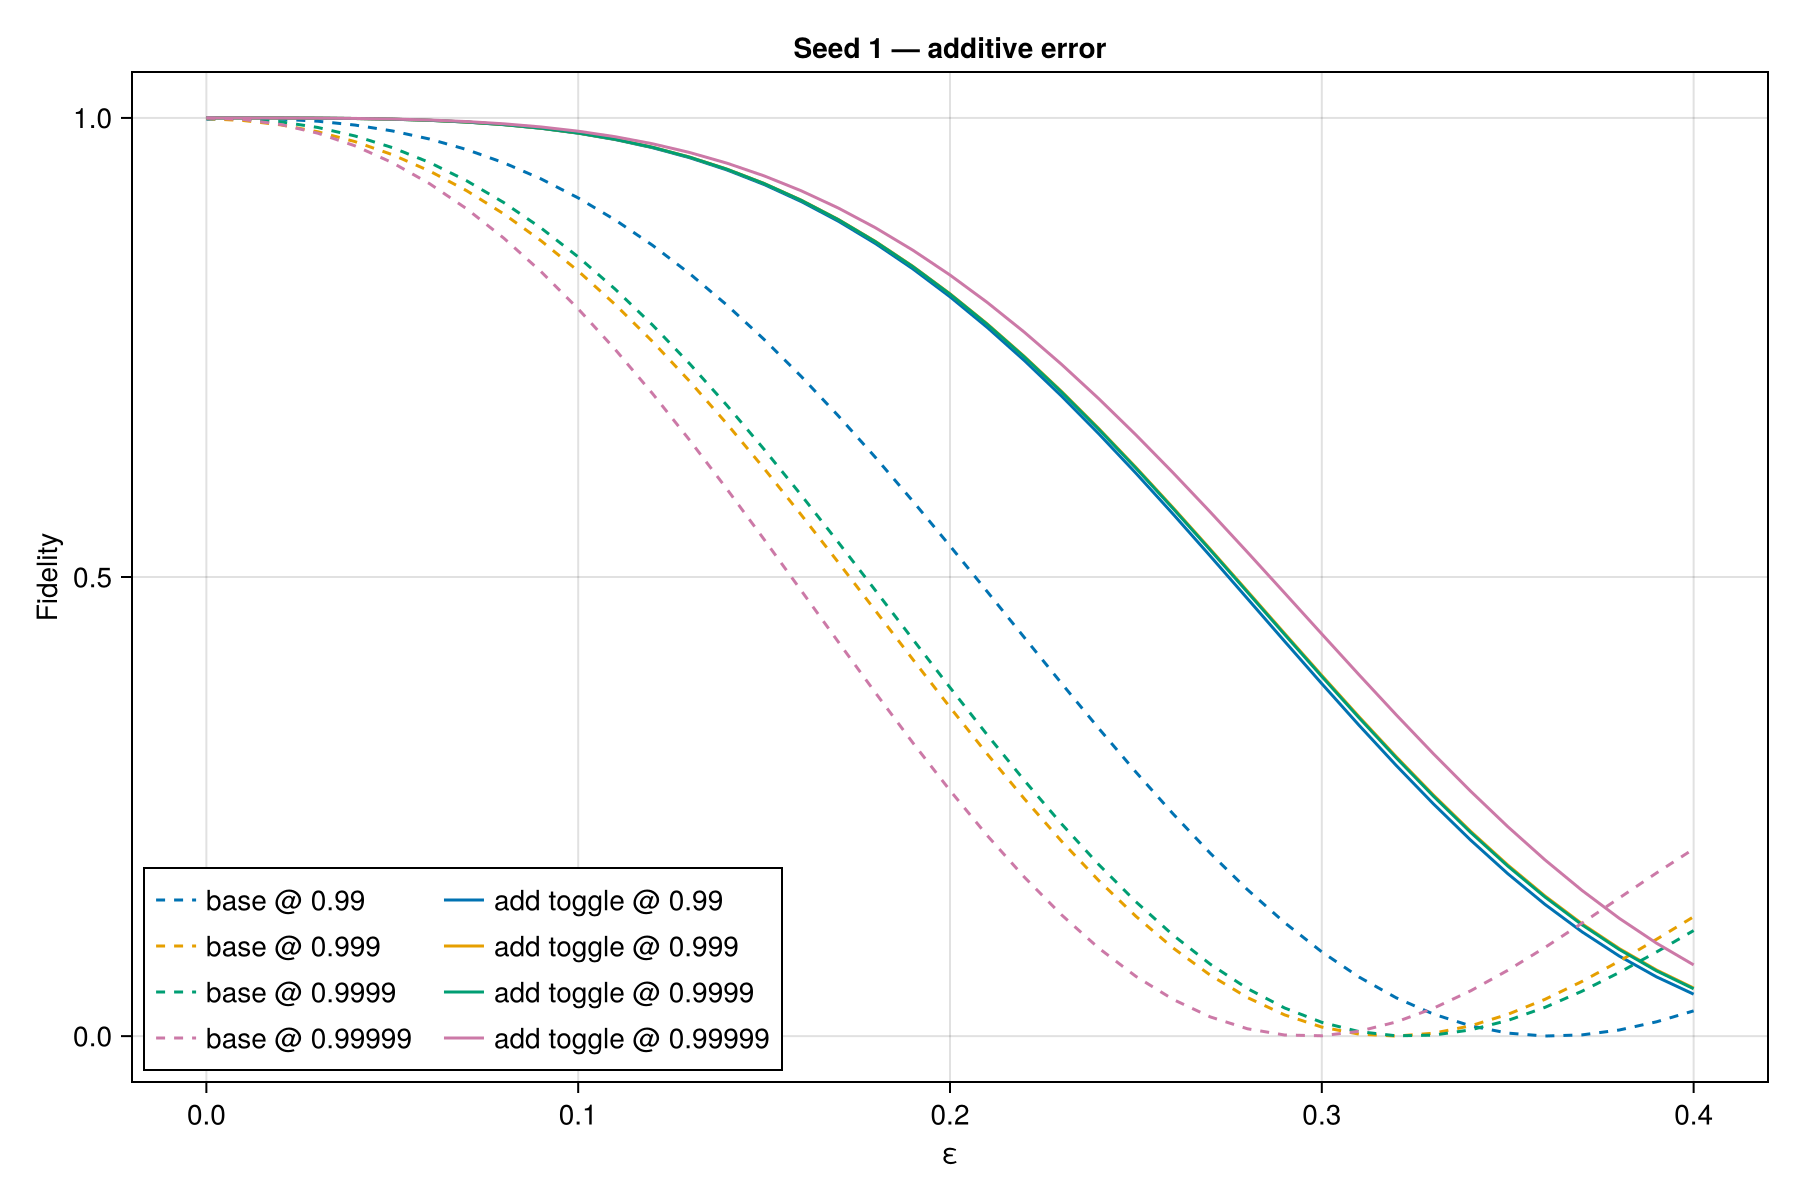

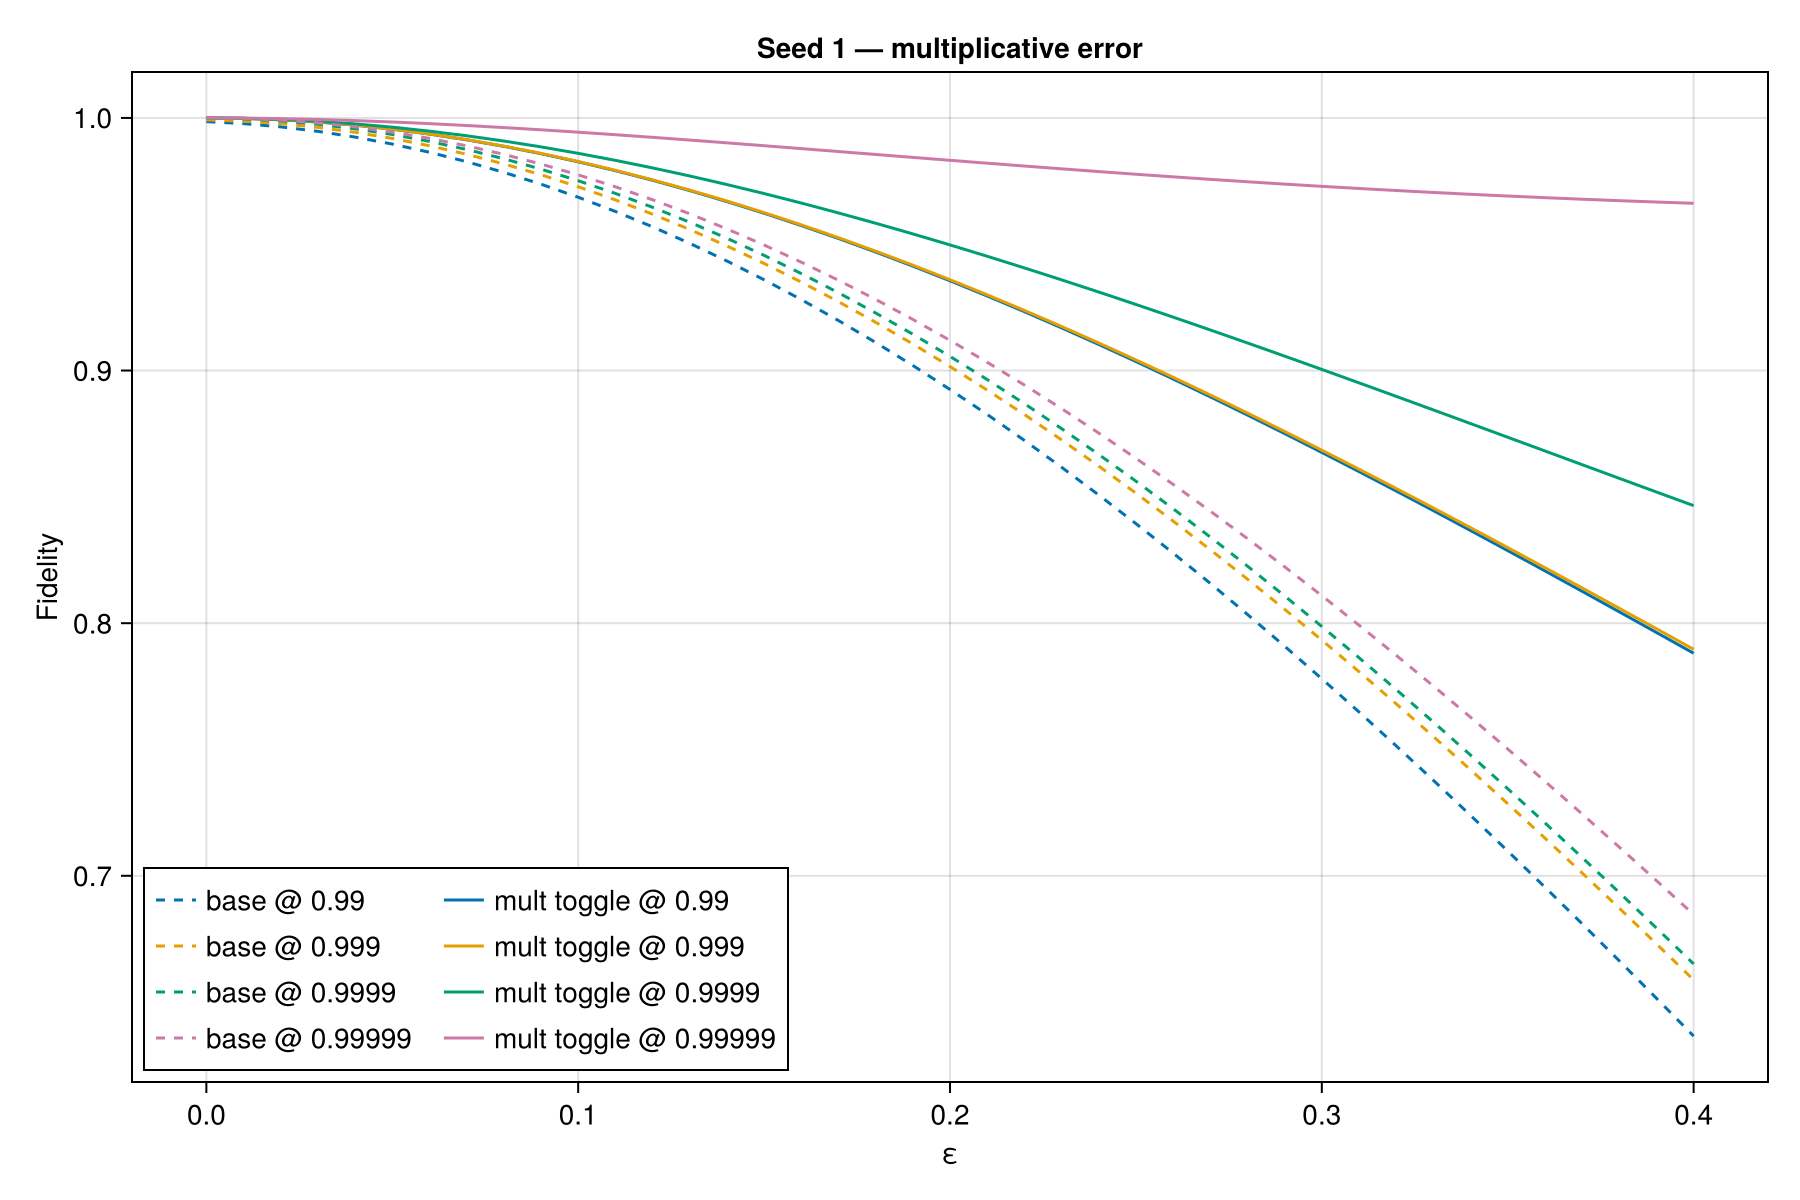

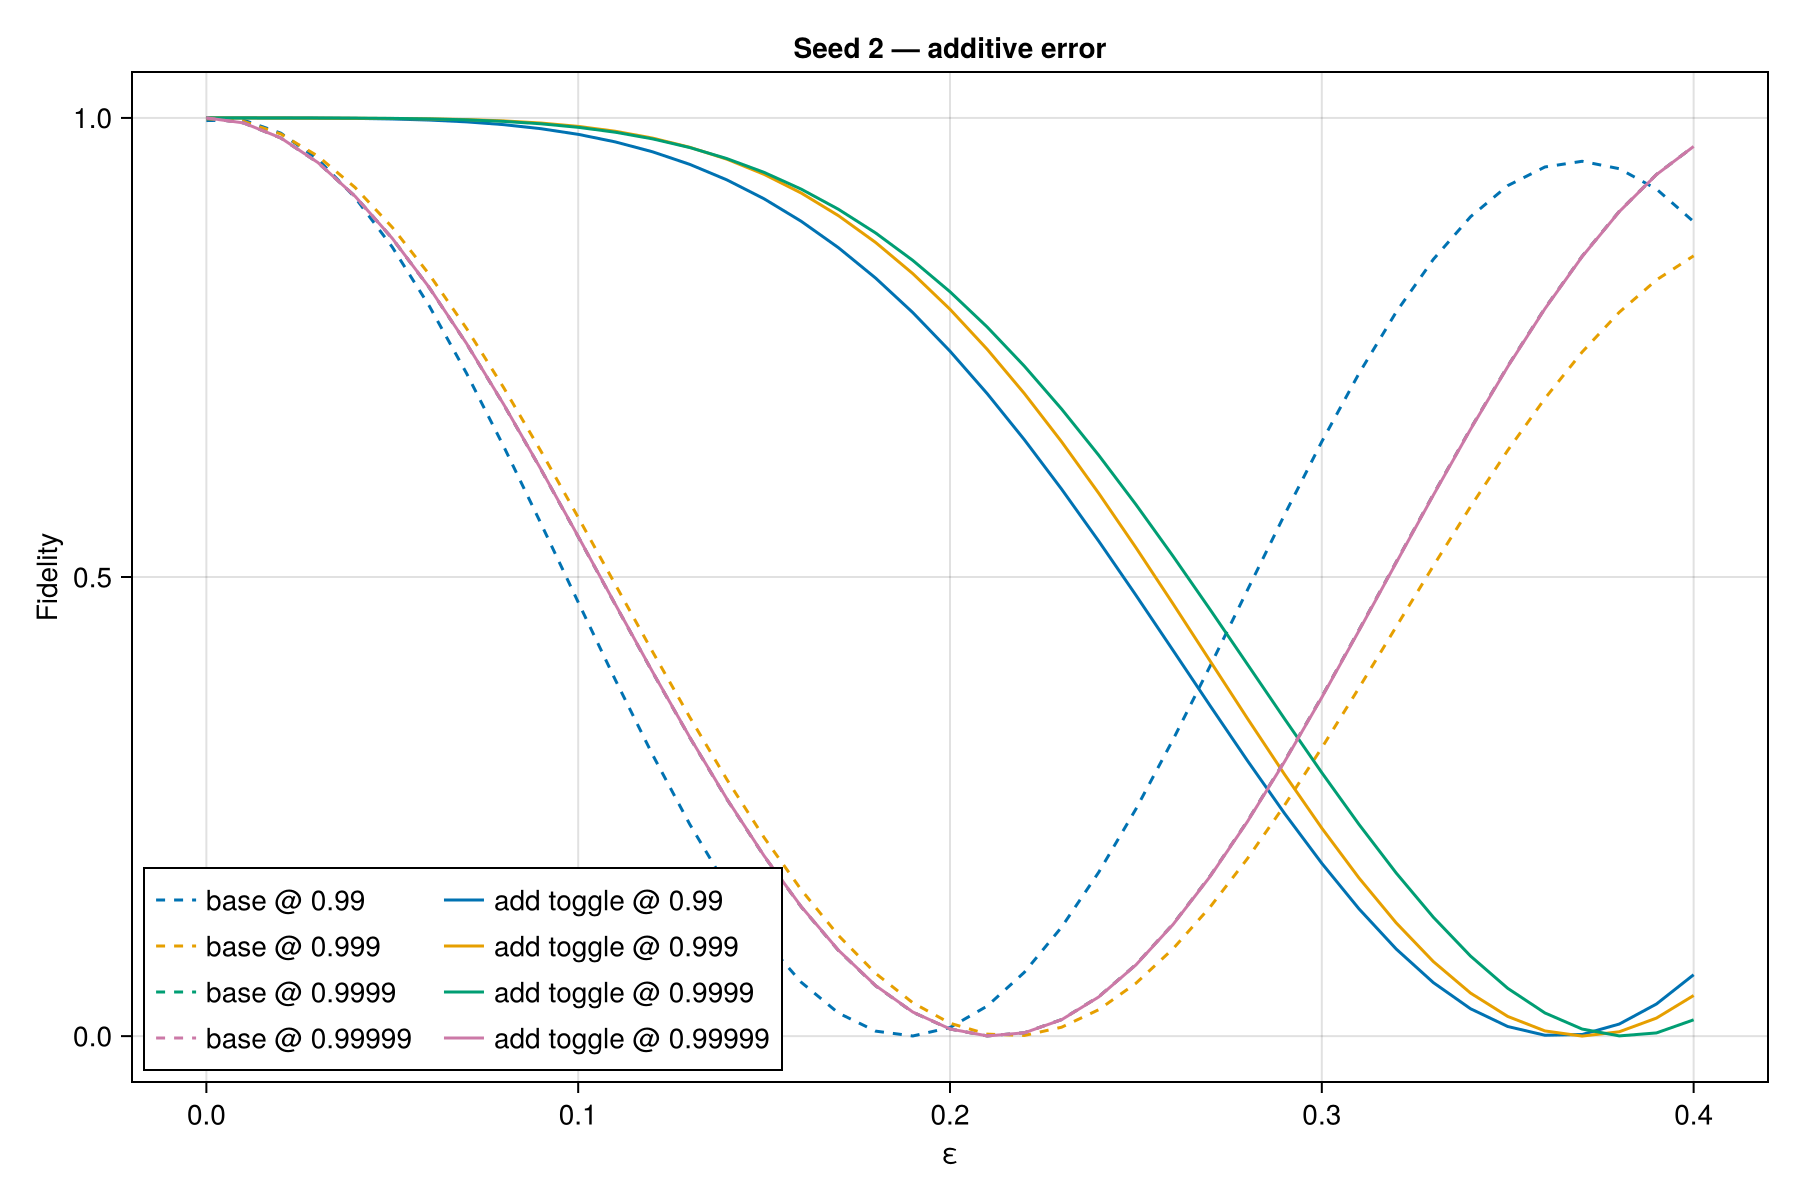

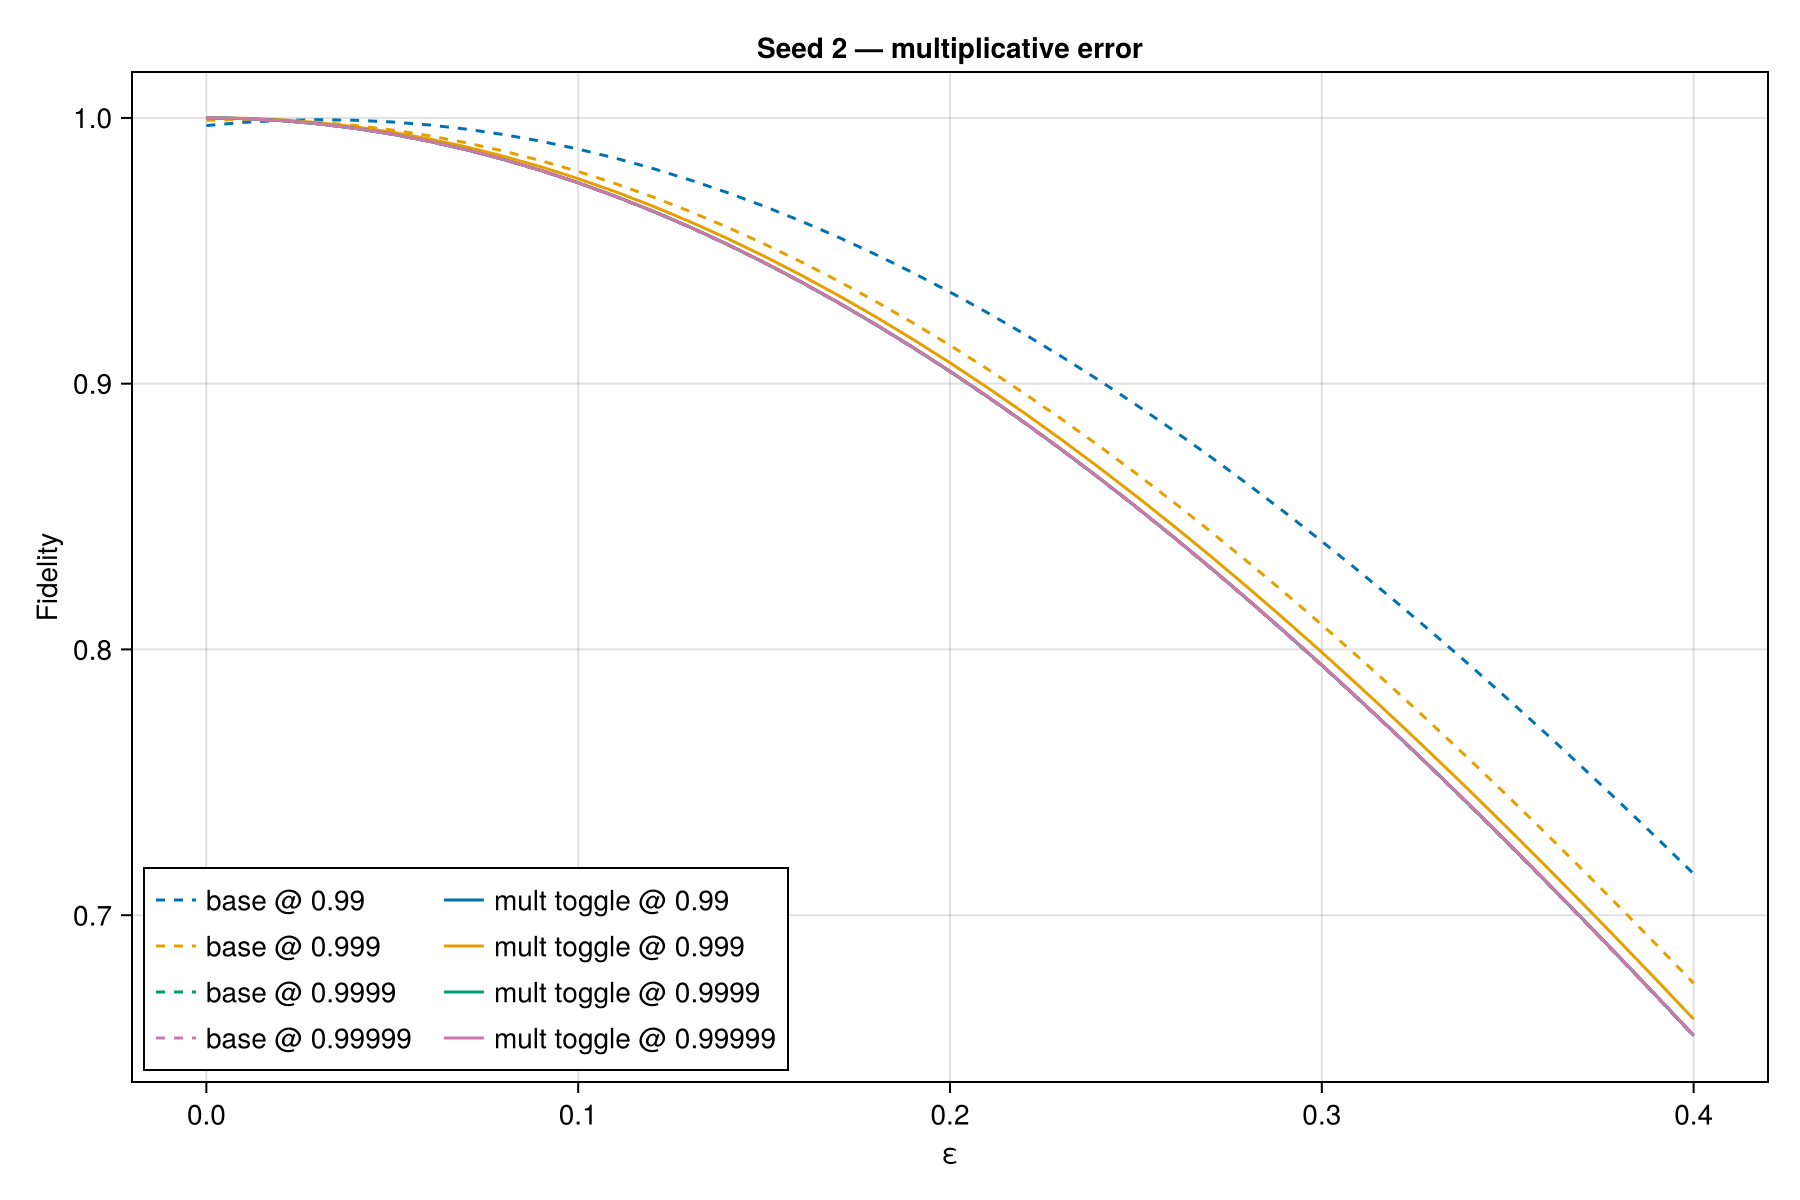

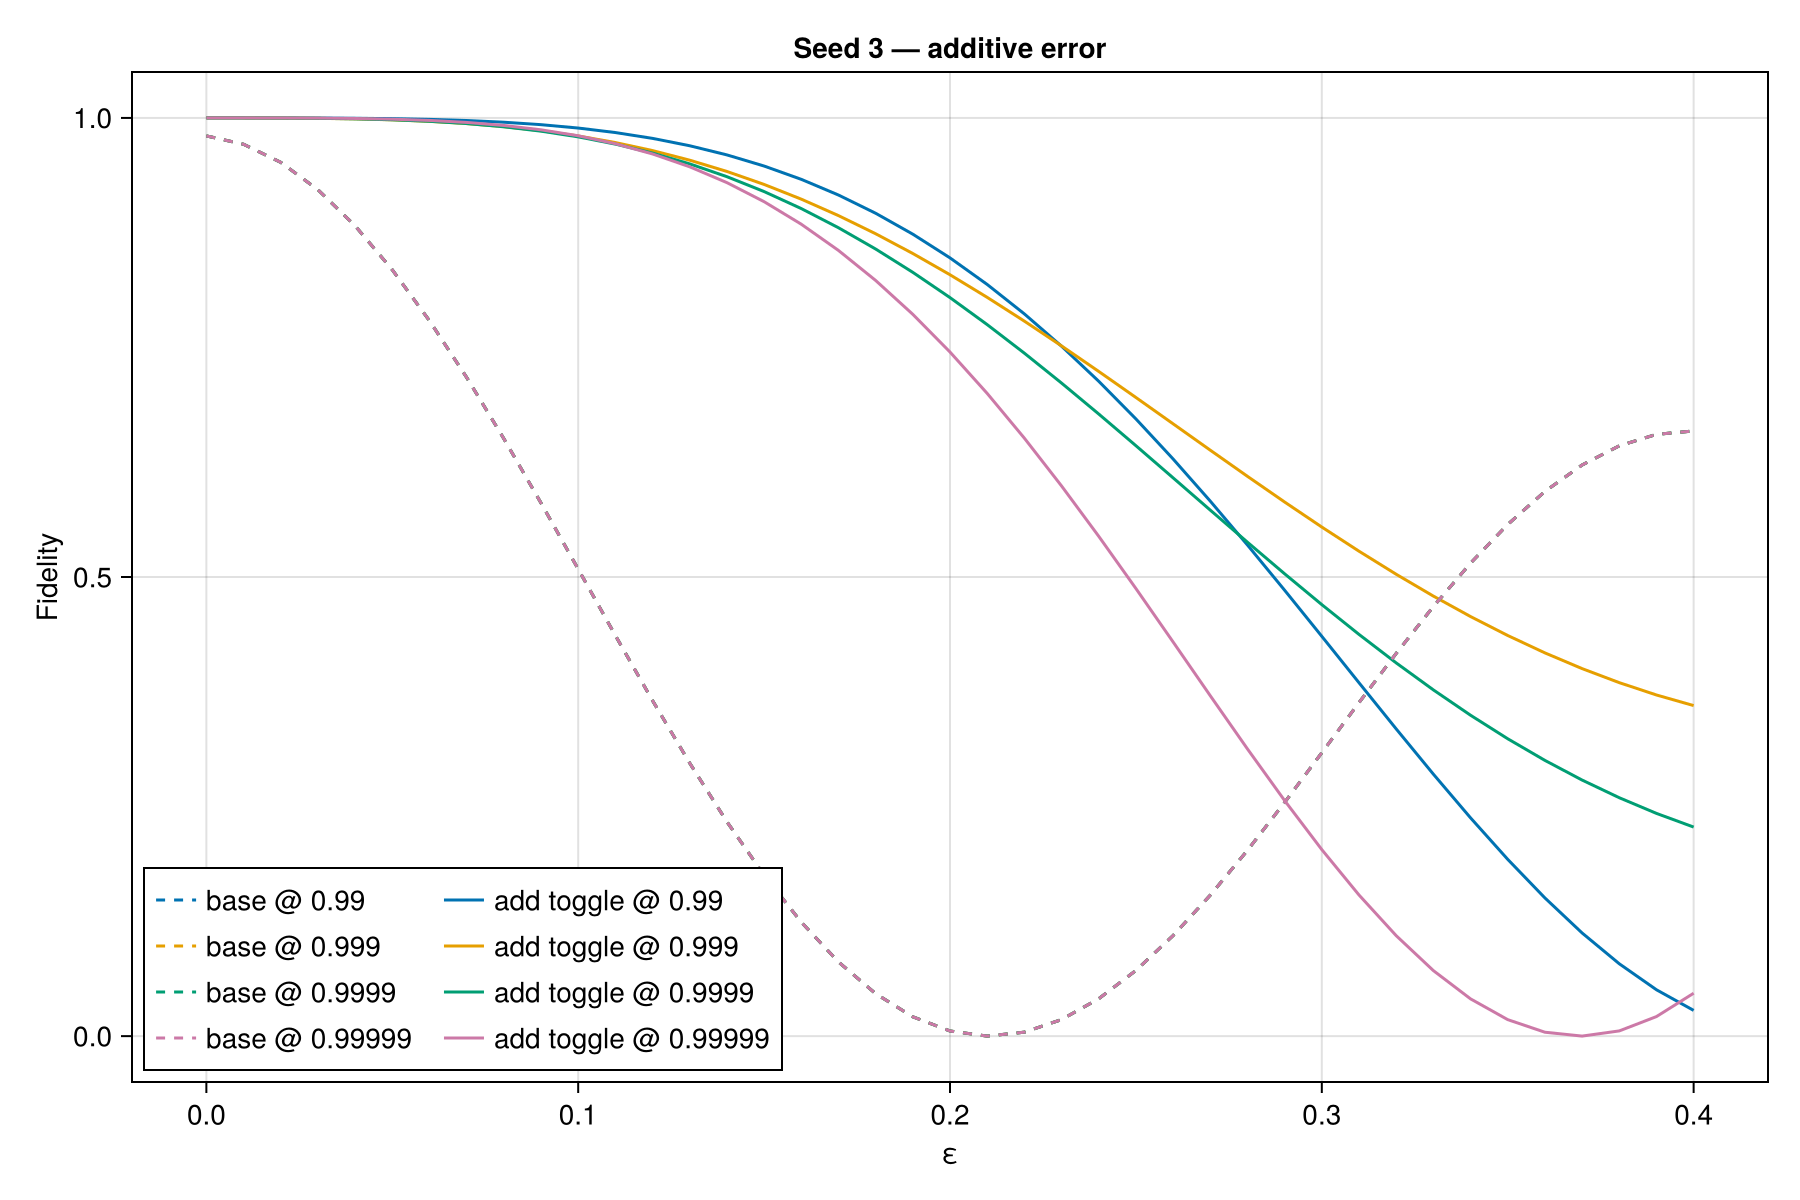

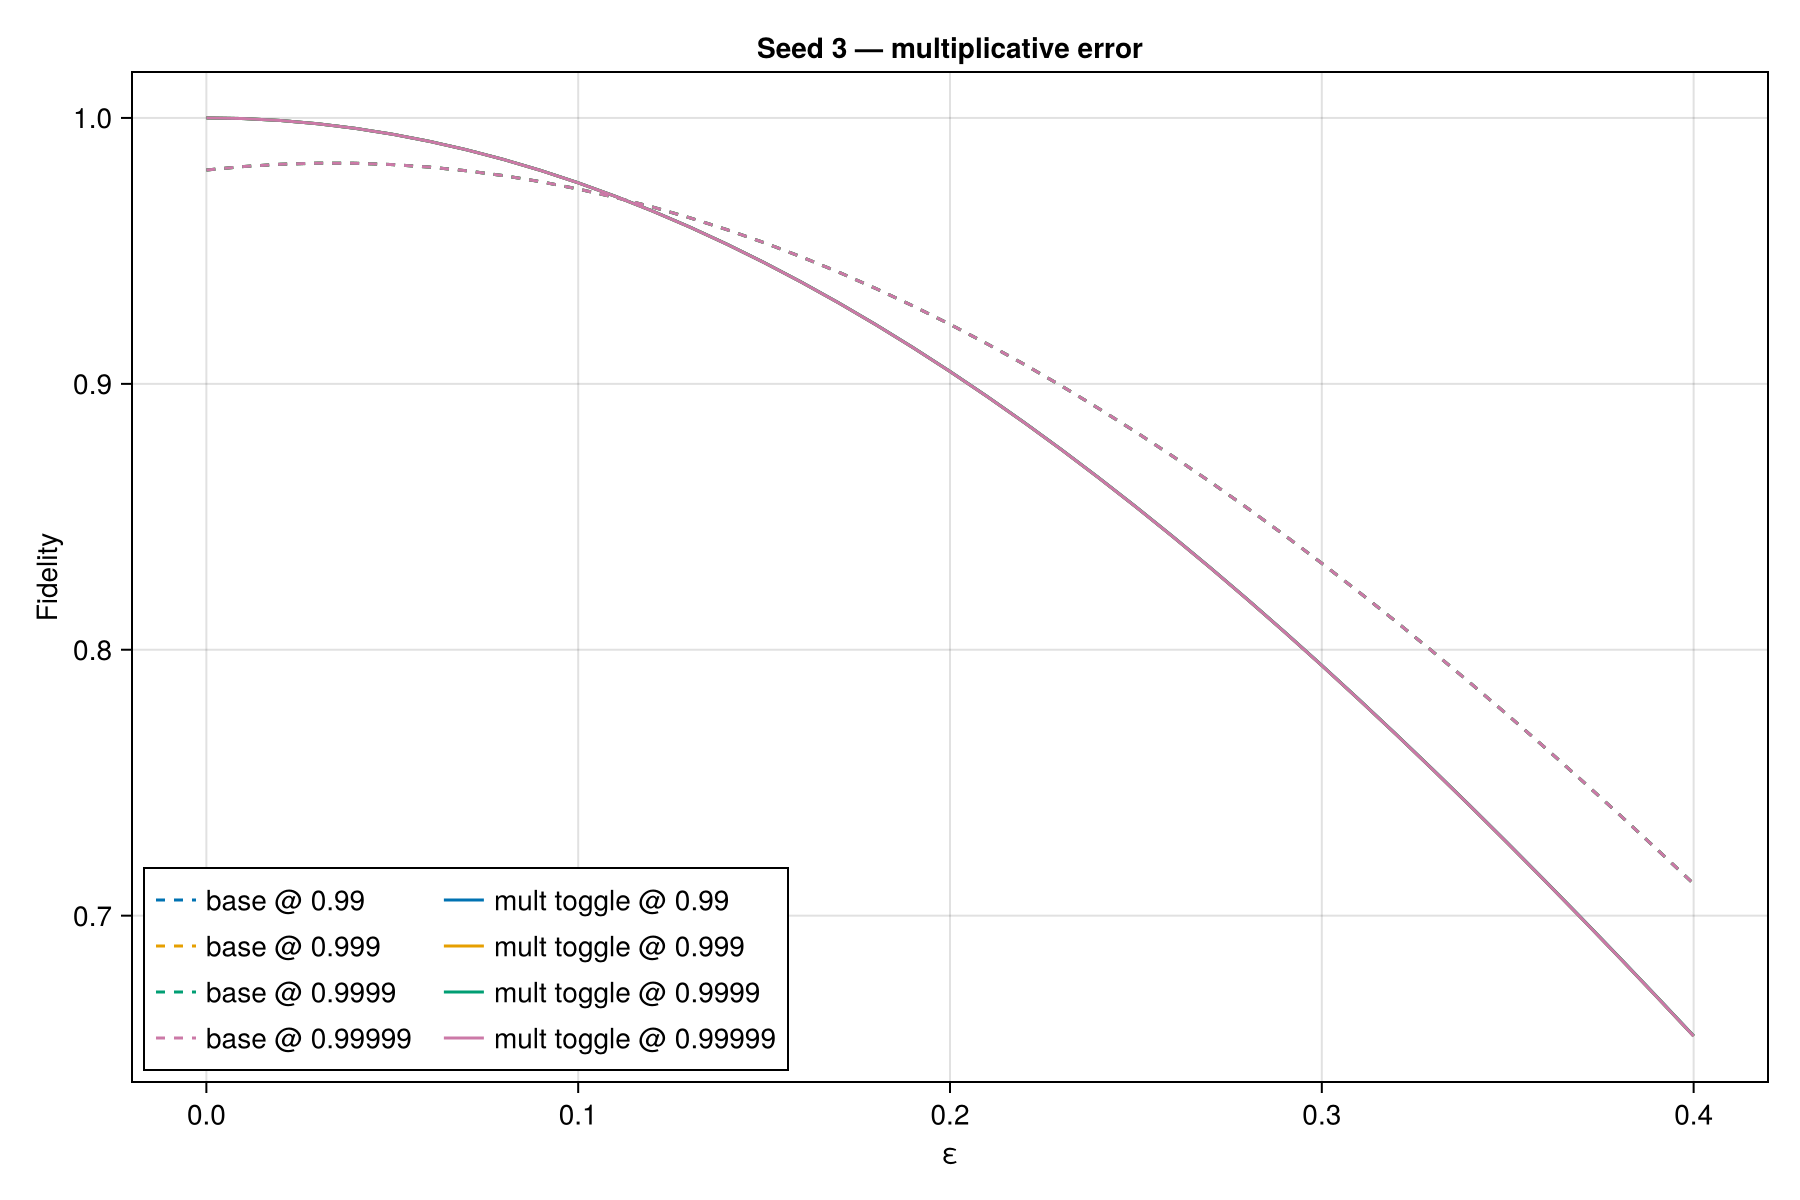

In [12]:
εs = 0:0.01:0.4
floors = final_fid_floor
colors = Makie.wong_colors()

# Helper to plot one seed, additive-only
function plot_seed_additive(seed_idx; εs=εs, floors=floors)
    fig = Figure(resolution=(900,600))
    ax = Axis(fig[1,1];
        title = "Seed $(seed_idx) — additive error",
        xlabel = "ε",
        ylabel = "Fidelity"
    )

    for j in 1:length(floors)
        c = colors[mod1(j, length(colors))]
        # Base (default) trajectory at this floor
        def_traj  = default_probs[seed_idx, j].trajectory
        # Optimized (toggle) trajectory at this floor
        add_traj  = final_add_probs[seed_idx, j].trajectory

        ys_def = [unitary_rollout_fidelity(
                      def_traj,
                      QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
                  ) for ε in εs]
        ys_add = [unitary_rollout_fidelity(
                      add_traj,
                      QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])
                  ) for ε in εs]

        # same color for the pair; dashed = base, solid = optimized
        lines!(ax, εs, ys_def, color=c, linestyle=:dash,
               label="base @ $(round(floors[j]; digits=6))")
        lines!(ax, εs, ys_add, color=c, linestyle=:solid,
               label="add toggle @ $(round(floors[j]; digits=6))")
    end

    axislegend(ax, position=:lb, nbanks=2)
    fig
end

# Helper to plot one seed, multiplicative-only
function plot_seed_multiplicative(seed_idx; εs=εs, floors=floors)
    fig = Figure(resolution=(900,600))
    ax = Axis(fig[1,1];
        title = "Seed $(seed_idx) — multiplicative error",
        xlabel = "ε",
        ylabel = "Fidelity"
    )

    for j in 1:length(floors)
        c = colors[mod1(j, length(colors))]
        # Base (default) trajectory at this floor
        def_traj   = default_probs[seed_idx, j].trajectory
        # Optimized (toggle) trajectory at this floor
        mult_traj  = final_mult_probs[seed_idx, j].trajectory

        ys_def = [unitary_rollout_fidelity(
                      def_traj,
                      QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
                  ) for ε in εs]
        ys_mult = [unitary_rollout_fidelity(
                       mult_traj,
                       QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])
                   ) for ε in εs]

        lines!(ax, εs, ys_def, color=c, linestyle=:dash,
               label="base @ $(round(floors[j]; digits=6))")
        lines!(ax, εs, ys_mult, color=c, linestyle=:solid,
               label="mult toggle @ $(round(floors[j]; digits=6))")
    end

    axislegend(ax, position=:lb, nbanks=2)
    fig
end

# Create & save the figures per seed
for i in 1:n_seeds
    fig_add  = plot_seed_additive(i)
    fig_mult = plot_seed_multiplicative(i)

    save("seed_$(i)_additive_fidelity.png", fig_add)
    save("seed_$(i)_multiplicative_fidelity.png", fig_mult)

    display(fig_add)
    display(fig_mult)
end
